In [1]:
# Import all the things

import json
import pandas as pd
import numpy as np
import wrangle
import acquire
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords, prep_string_data#, split_data

import re
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# use our own wrangle to get the data
# df = wrangle.get_npr_data()
# df.head()

### I'm interested in topic modeling on a story-level basis
### So I will need to groupby story_id_num

In [3]:
# df = df.sort_values(by=['story_id_num','utterance_order'])
# df.head()

In [4]:
# df = df[['story_id_num','utterance_order','title','lemmatized']]

In [5]:
# df_sample = df[:100]
# df_sample

In [6]:
# df_sample.shape

In [7]:
# pd.DataFrame(df_sample.groupby('title').apply(list).reset_index())

In [8]:
# df_sample.groupby(['story_id_num']).title.first()

In [9]:
# # group every story as an aggregation of all its utterances
# df_sample.groupby(['story_id_num']).lemmatized.agg(' '.join)#.iloc[0]

In [10]:
# # group every story as an aggregation of all its utterances and store in a DF
# stories_test = pd.DataFrame(df_sample.groupby(['story_id_num']).lemmatized.agg(' '.join))
# stories_test

In [11]:
# stories.iloc[0].values

### Run the above on the whole df

In [12]:
# df = df.sort_values(by=['story_id_num','utterance_order'])
# df.head()

In [13]:
# df.dtypes

In [14]:
# df.isna().sum()

In [15]:
# df = df.dropna()

#### well...it worked on the sample above
#### had to drop 2 nulls that existed in the lemmatized column

In [16]:
# # group every story as an aggregation of all its utterances and store in a DF
# stories = pd.DataFrame(df.groupby(['story_id_num']).lemmatized.agg(' '.join))
# stories

-  61,165 stories to work with here

In [17]:
# this attempt to get the word count for every story isn't working currently
# stories['word_count'] = df.lemmatized.apply(str.split).apply(len)
# stories.head()

In [18]:
# sia = nltk.sentiment.SentimentIntensityAnalyzer()
# stories['vader'] = stories.lemmatized.apply(lambda doc: sia.polarity_scores(doc)['compound'])
# stories.head()

In [19]:
# stories.to_csv('stories.csv')

In [20]:
stories = pd.read_csv('stories.csv')
stories.head()

,Unnamed: 0,story_id_num,lemmatized,vader,title,date
0,0,17,he is in cahoot with a foreign government to m...,0.9964,n.j. democrat on reported whistleblower compla...,2019-09-22
1,1,18,"come with concrete plan , not beautiful speech...",0.9993,"ahead of climate summit, 2 views from cities i...",2019-09-22
2,2,19,if you stand outside the old dekalb county cou...,0.9974,"barred from removing confederate monument, cou...",2019-09-22
3,3,20,you may have spotted pink salt in your superma...,0.4950,pakistan's pink himalayan salt has become a ma...,2019-09-22
4,4,21,"singing in foreign language . the other day , ...",0.9730,"10 years after haiti's earthquake, 'this music...",2019-09-22


In [21]:
stories = stories.drop(columns = ['Unnamed: 0'])

In [22]:
stories.shape

(61165, 5)

In [23]:
# len(df.groupby(['story_id_num']).title.first())

In [24]:
# stories['title'] = df.groupby(['story_id_num']).title.first().tolist()

In [25]:
stories.head()

,story_id_num,lemmatized,vader,title,date
0,17,he is in cahoot with a foreign government to m...,0.9964,n.j. democrat on reported whistleblower compla...,2019-09-22
1,18,"come with concrete plan , not beautiful speech...",0.9993,"ahead of climate summit, 2 views from cities i...",2019-09-22
2,19,if you stand outside the old dekalb county cou...,0.9974,"barred from removing confederate monument, cou...",2019-09-22
3,20,you may have spotted pink salt in your superma...,0.4950,pakistan's pink himalayan salt has become a ma...,2019-09-22
4,21,"singing in foreign language . the other day , ...",0.9730,"10 years after haiti's earthquake, 'this music...",2019-09-22


In [26]:
# stories.to_csv('stories.csv')

In [27]:
stories.vader.idxmax()

39

In [28]:
# stories.lemmatized[39]

In [29]:
stories.title[39]

'so hard to say goodbye: advice for farewell notes'

The first highest-sentiment article is about hallmark greeting cards

In [30]:
stories[stories.vader == 1]

,story_id_num,lemmatized,vader,title,date
39,620,"looking ahead to our last day , many of our fr...",1.0,so hard to say goodbye: advice for farewell notes,2013-06-27
42,623,"this is talk of the nation. i m neal conan , i...",1.0,a look ahead and a farewell to the political j...,2013-06-26
43,624,"this is talk of the nation. i m neal conan , i...",1.0,what changes after supreme court rulings on pr...,2013-06-26
44,625,"from small country church , to the stage of th...",1.0,gospel legend mavis staples comes 'full circle',2013-06-26
141,898,this is talk of the nation. i m neal conan in ...,1.0,'blood &amp; beauty' breathes new life into th...,2013-06-20
...,...,...,...,...,...
23796,84430,this is talk of the nation. i m neal conan in ...,1.0,state legislatures: agendas and budgets,2005-01-11
23995,84850,time now for a story that is decidedly not a n...,1.0,encore: an elf questions santa's naughty or ni...,2016-12-23
27366,90916,the political campaign are taking a break. the...,1.0,santa for president in 2016,2015-12-25
30850,96419,"now we re going to take a break from news , fr...",1.0,listen: the not-so-true story of santa's naugh...,2014-12-25


- Actually...there are 1345 stories with a max vader score

In [31]:
brightest_stories = stories[stories.vader == 1]
brightest_stories

,story_id_num,lemmatized,vader,title,date
39,620,"looking ahead to our last day , many of our fr...",1.0,so hard to say goodbye: advice for farewell notes,2013-06-27
42,623,"this is talk of the nation. i m neal conan , i...",1.0,a look ahead and a farewell to the political j...,2013-06-26
43,624,"this is talk of the nation. i m neal conan , i...",1.0,what changes after supreme court rulings on pr...,2013-06-26
44,625,"from small country church , to the stage of th...",1.0,gospel legend mavis staples comes 'full circle',2013-06-26
141,898,this is talk of the nation. i m neal conan in ...,1.0,'blood &amp; beauty' breathes new life into th...,2013-06-20
...,...,...,...,...,...
23796,84430,this is talk of the nation. i m neal conan in ...,1.0,state legislatures: agendas and budgets,2005-01-11
23995,84850,time now for a story that is decidedly not a n...,1.0,encore: an elf questions santa's naughty or ni...,2016-12-23
27366,90916,the political campaign are taking a break. the...,1.0,santa for president in 2016,2015-12-25
30850,96419,"now we re going to take a break from news , fr...",1.0,listen: the not-so-true story of santa's naugh...,2014-12-25


In [32]:
brightest_stories.title.sample(10).to_list()

["'the smart patient': how to get the best care",
 'exploring the relationship between music and memory',
 'whose consumer reviews do you most trust?',
 'michelle obama, hillary clinton speak in denver',
 'evaluating self-improvement gurus',
 'modern girls and the modesty movement',
 'white sox faithful smell world series victory',
 "'parenting inc.' explores high price of parenting",
 'as arguments wrap, future of health law is unclear',
 'political junkie: update on the presidential campaign']

In [33]:
stories[stories.vader == -1]

,story_id_num,lemmatized,vader,title,date
749,2749,this is talk of the nation. i m neal conan in ...,-1.0,"the epidemiology of gun violence: race, region...",2013-03-26
5731,19881,this is talk of the nation. i m neal conan in ...,-1.0,how do you define a hate crime?,2012-03-19
10730,55411,"this is talk of the nation. i m neal conan , i...",-1.0,understanding suicide terrorism and how to sto...,2010-10-11
11827,58454,this is talk of the nation. im neal conan in w...,-1.0,deconstructing 'myths about suicide',2010-04-28
15177,66409,this is talk of the nation. i m neal conan in ...,-1.0,the legacy of bush's 'war on terror',2009-01-12
17237,71520,this is talk of the nation. i m neal conan in ...,-1.0,who carries out suicide bombings?,2008-01-22
18838,75087,this is talk of the nation. i m neal conan in ...,-1.0,how do we define terrorism?,2007-06-04
21189,79688,"this is talk of the nation. i m neal conan , i...",-1.0,should the guantanamo prison be closed?,2006-05-23
21287,79858,"from npr news in washington , dc , i m neal co...",-1.0,'war of nerves': a history of chemical weapons,2006-05-08


- But only 9 stories with the lowest vader score, including...

In [34]:
# stories.lemmatized[749]

In [35]:
stories.title[749]

'the epidemiology of gun violence: race, region and policy'

- A story aboout "gun death , race , sex and region"

In [36]:
darkest_stories = stories[stories.vader == -1]
darkest_stories

,story_id_num,lemmatized,vader,title,date
749,2749,this is talk of the nation. i m neal conan in ...,-1.0,"the epidemiology of gun violence: race, region...",2013-03-26
5731,19881,this is talk of the nation. i m neal conan in ...,-1.0,how do you define a hate crime?,2012-03-19
10730,55411,"this is talk of the nation. i m neal conan , i...",-1.0,understanding suicide terrorism and how to sto...,2010-10-11
11827,58454,this is talk of the nation. im neal conan in w...,-1.0,deconstructing 'myths about suicide',2010-04-28
15177,66409,this is talk of the nation. i m neal conan in ...,-1.0,the legacy of bush's 'war on terror',2009-01-12
17237,71520,this is talk of the nation. i m neal conan in ...,-1.0,who carries out suicide bombings?,2008-01-22
18838,75087,this is talk of the nation. i m neal conan in ...,-1.0,how do we define terrorism?,2007-06-04
21189,79688,"this is talk of the nation. i m neal conan , i...",-1.0,should the guantanamo prison be closed?,2006-05-23
21287,79858,"from npr news in washington , dc , i m neal co...",-1.0,'war of nerves': a history of chemical weapons,2006-05-08


In [37]:
for story in darkest_stories.title:
    print(story)

the epidemiology of gun violence: race, region and policy
how do you define a hate crime?
understanding suicide terrorism and how to stop it
deconstructing 'myths about suicide'
the legacy of bush's 'war on terror'
who carries out suicide bombings?
how do we define terrorism?
should the guantanamo prison be closed?
'war of nerves': a history of chemical weapons


- Here's a list of the stories with the lowest possible sentiment score

In [38]:
brightest_stories = stories[stories.vader == 1]
brightest_stories.head(1)

,story_id_num,lemmatized,vader,title,date
39,620,"looking ahead to our last day , many of our fr...",1.0,so hard to say goodbye: advice for farewell notes,2013-06-27


In [39]:
brightest_stories_title_list = []
for story in brightest_stories.title:
    brightest_stories_title_list.append(story)

In [40]:
# brightest_stories_title_list = pd.DataFrame(brightest_stories_title_list)
brightest_stories_title_list[:30]

['so hard to say goodbye: advice for farewell notes',
 'a look ahead and a farewell to the political junkie',
 'what changes after supreme court rulings on prop 8 and doma',
 "gospel legend mavis staples comes 'full circle'",
 "'blood &amp; beauty' breathes new life into the borgias",
 'the penultimate edition of the political junkie',
 'will work for free? the future of the unpaid internship',
 "india.arie returns, with an eye toward a new 'songversation'",
 "from 'casablanca' to 'e.t. the extra-terrestrial': famous farewells in film",
 'inside the cel: behind the scenes with animators',
 'a look ahead to the future of the gop',
 'the scifri book club takes a hike',
 'the role of the attorney general throughout history',
 'cartoonist lynda barry helps college students tap innate creativity',
 'looking ahead with the wonders of krulwich',
 'the promise and limitations of telemedicine',
 "iowa's open senate seat and rumbles about 2016",
 'hospital costs go public: what changes in health

-  At first glance, these brightest stories seem to mostly belong to a 'human interest' typee news category

In [41]:
# stories.lemmatized[stories.title == "iowa's open senate seat and rumbles about 2016"].values

- One oddball example in the bright stories, unusually about politics

In [42]:
stories.head()

,story_id_num,lemmatized,vader,title,date
0,17,he is in cahoot with a foreign government to m...,0.9964,n.j. democrat on reported whistleblower compla...,2019-09-22
1,18,"come with concrete plan , not beautiful speech...",0.9993,"ahead of climate summit, 2 views from cities i...",2019-09-22
2,19,if you stand outside the old dekalb county cou...,0.9974,"barred from removing confederate monument, cou...",2019-09-22
3,20,you may have spotted pink salt in your superma...,0.4950,pakistan's pink himalayan salt has become a ma...,2019-09-22
4,21,"singing in foreign language . the other day , ...",0.9730,"10 years after haiti's earthquake, 'this music...",2019-09-22


In [43]:
# get dates for the stories from original df
# stories['date'] = df.groupby(['story_id_num']).date.first().tolist()

In [44]:
# get new csv
# stories.to_csv("stories.csv")

In [45]:
stories.date = pd.to_datetime(stories.date)

In [46]:
stories.dtypes

story_id_num             int64
lemmatized              object
vader                  float64
title                   object
date            datetime64[ns]
dtype: object

In [47]:
# assign new df for tsa looksy
tsa = stories.set_index(stories.date).sort_index()
tsa.head()

,story_id_num,lemmatized,vader,title,date
date,,,,,
2005-01-11,84430,this is talk of the nation. i m neal conan in ...,1.0000,state legislatures: agendas and budgets,2005-01-11
2005-01-11,84432,this is talk of the nation. i m neal conan in ...,0.9999,difference between a think and a 'blink',2005-01-11
2005-01-11,84433,this is talk of the nation. i m neal conan in ...,0.9999,bush picks judge to head homeland security,2005-01-11
2005-01-11,84434,scientist at the national oceanic and atmosphe...,0.9914,noaa aims for predicting tsunamis,2005-01-11
2005-01-11,84431,this is talk of the nation. i m neal conan in ...,0.9999,california rains bring rash of mudslides,2005-01-11


<AxesSubplot:xlabel='date'>

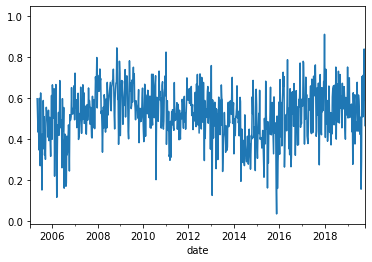

In [48]:
# plot stories by sentiment, resampled weekly, averaged out
tsa.vader.resample('w').mean().plot()

In [49]:
# assign new df for the weekly sample of vader
weekly_tsa=pd.DataFrame(tsa.vader.resample('w').mean())
weekly_tsa

,vader
date,
2005-01-16,0.998220
2005-01-23,NaN
2005-01-30,0.999800
2005-02-06,NaN
2005-02-13,NaN
...,...
2019-09-15,0.712144
2019-09-22,0.589789
2019-09-29,0.839537


In [50]:
# drop 14 nulls
weekly_tsa = weekly_tsa.dropna()
weekly_tsa.isna().sum()

vader    0
dtype: int64

In [51]:
# add vader difference from week to week
weekly_tsa['weekly_diff']= weekly_tsa.vader.diff(1)
weekly_tsa.head()

,vader,weekly_diff
date,,
2005-01-16,0.998220,NaN
2005-01-30,0.999800,0.001580
2005-05-08,0.596417,-0.403383
2005-05-15,0.503421,-0.092997
2005-05-22,0.433512,-0.069909


### What week saw the biggest drop in sentiment?  

In [52]:
weekly_tsa.weekly_diff.idxmin()

Timestamp('2010-08-01 00:00:00')

- At Least 400 Killed in Pakistan Floods (July 30)
- Plane Crash in Pakistan Kills All 152 on Board (July 28)
- U.S. Economy Lost 131,000 Jobs in July; Unemployment Remains at 9.5% (Aug. 6)
- CA Gay Marriage Ban Overturned (Aug. 4)

### Not a lot of concrete evidence of what would cause such a drop

### And the biggest increasee?

In [53]:
weekly_tsa.weekly_diff.idxmax()

Timestamp('2015-11-29 00:00:00')

- 13November2015: Paris terrorist attacks
- Three Killed at Planned Parenthood Shooting in Colorado Springs (Nov. 27)
- Russian Airliner Brought Down by Bomb (Nov. 17)

### Again, nothing concrete: an index of the noise in the data

## Below begins my attempt to use gensim for LDA topic modeling

In [54]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = stories.lemmatized.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianclements/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['cahoot', 'foreign', 'government', 'manipulate', 'outcome', 'election', 'comment', 'democratic', 'presidential', 'candidate', 'california', 'senator', 'kamala', 'harris', 'impeachable', 'close', 'call', 'hawaii', 'senator', 'brian', 'schatz', 'new', 'york', 'congresswoman', 'alexandria', 'ocasio', 'cortez', 'point', 'beyond', 'constitutional']


In [55]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 3), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 4)]


In [56]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"wa" + 0.012*"know" + 0.008*"people" + 0.007*"like" + 0.007*"going" + '
  '0.007*"one" + 0.007*"think" + 0.007*"ha" + 0.006*"say" + 0.006*"much"'),
 (1,
  '0.014*"know" + 0.012*"wa" + 0.008*"like" + 0.008*"think" + 0.007*"people" + '
  '0.006*"thing" + 0.006*"get" + 0.006*"well" + 0.006*"going" + 0.006*"ha"'),
 (2,
  '0.017*"wa" + 0.009*"know" + 0.009*"like" + 0.008*"people" + 0.008*"well" + '
  '0.008*"one" + 0.007*"think" + 0.006*"say" + 0.006*"time" + 0.005*"would"'),
 (3,
  '0.015*"wa" + 0.010*"think" + 0.009*"know" + 0.008*"people" + 0.007*"say" + '
  '0.007*"well" + 0.007*"ha" + 0.006*"right" + 0.006*"year" + 0.006*"one"'),
 (4,
  '0.020*"wa" + 0.010*"know" + 0.009*"people" + 0.008*"one" + 0.007*"say" + '
  '0.007*"think" + 0.005*"time" + 0.005*"go" + 0.005*"ha" + 0.005*"like"'),
 (5,
  '0.010*"wa" + 0.009*"people" + 0.008*"say" + 0.008*"know" + 0.007*"year" + '
  '0.006*"going" + 0.006*"well" + 0.006*"one" + 0.006*"would" + 0.006*"ha"'),
 (6,
  '0.011*"wa" + 0.008*

In [57]:
# import pyLDAvis.gensim
import os
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
# LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+ str(num_topics)+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
#     LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.027976 -0.003206       1        1  24.646688
5      0.007570  0.015073       2        1  13.883102
0     -0.009808  0.004673       3        1   9.589315
4     -0.003748 -0.004798       4        1   9.506743
8     -0.008201  0.001728       5        1   8.558133
2     -0.006408 -0.000609       6        1   7.962434
3      0.001801 -0.005629       7        1   7.839609
7     -0.003030 -0.003523       8        1   6.702307
1     -0.005476 -0.002223       9        1   6.600792
9     -0.000675 -0.001486      10        1   4.710877, topic_info=      Term           Freq          Total Category  logprob  loglift
224     wa  457930.000000  457930.000000  Default  30.0000  30.0000
114   know  322481.000000  322481.000000  Default  29.0000  29.0000
202  think  233269.000000  233269.000000  Default  28.0000  28.0000
122   like  199117.000000  199117.000000  Default  27.0000  27.0000
227   well  194724.000000  194724.000000  Default  26.0000  26.0000
..     ...            ...            ...      ...      ...      ...
86      ha    8203.603349  211075.618775  Topic10  -5.2620  -0.1923
178    say    8796.265682  237964.253650  Topic10  -5.1922  -0.2425
122   like    7703.566355  199117.585506  Topic10  -5.3249  -0.1969
448    see    4828.396923   95483.689343  Topic10  -5.7920   0.0709
225   want    4791.481833  100693.048960  Topic10  -5.7997   0.0101

[917 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
21922      1  0.495184  abbas
21922      2  0.072418  abbas
21922      3  0.016637  abbas
21922      4  0.023487  abbas
21922      5  0.017615  abbas
...      ...       ...    ...
65615      6  0.014595  zandi
65615      7  0.009730  zandi
65615      8  0.014595  zandi
65615      9  0.014595  zandi
65615     10  0.009730  zandi

[4247 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 1, 5, 9, 3, 4, 8, 2, 10])

## The same...but running it on the titles instead of the corpi

In [58]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = stories.title.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianclements/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['democrat', 'reported', 'whistleblower', 'complaint', 'trump']


In [59]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


In [60]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.004*"help" + 0.004*"oil" + 0.004*"president" + 0.003*"week" + '
  '0.003*"china" + 0.003*"election" + 0.003*"may" + 0.003*"economy" + '
  '0.003*"health" + 0.003*"dies"'),
 (1,
  '0.005*"new" + 0.004*"years" + 0.004*"china" + 0.004*"program" + '
  '0.004*"news" + 0.003*"class" + 0.003*"show" + 0.003*"house" + 0.003*"top" + '
  '0.003*"political"'),
 (2,
  '0.010*"obama" + 0.008*"iraq" + 0.005*"politics" + 0.005*"trump" + '
  '0.005*"week" + 0.004*"new" + 0.004*"iran" + 0.004*"election" + '
  '0.004*"court" + 0.004*"policy"'),
 (3,
  '0.025*"new" + 0.007*"orleans" + 0.007*"program" + 0.006*"class" + '
  '0.006*"obama" + 0.005*"court" + 0.005*"iran" + 0.004*"public" + '
  '0.004*"news" + 0.004*"life"'),
 (4,
  '0.009*"new" + 0.005*"change" + 0.004*"president" + 0.004*"black" + '
  '0.004*"obama" + 0.004*"climate" + 0.003*"government" + 0.003*"letters" + '
  '0.003*"years" + 0.003*"may"'),
 (5,
  '0.011*"new" + 0.006*"letters" + 0.005*"obama" + 0.005*"trump" + '
  '0.004*"news" 

In [61]:
# import pyLDAvis.gensim
import os
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
# LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+ str(num_topics)+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
#     LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.086887  0.073922       1        1  11.652804
5      0.025912 -0.004520       2        1  10.728494
7     -0.027102  0.023677       3        1  10.498812
6     -0.048399 -0.009861       4        1  10.338504
2     -0.123556 -0.014611       5        1  10.189431
0     -0.023342  0.114104       6        1   9.636027
3      0.036844 -0.014075       7        1   9.598940
8     -0.008027 -0.043759       8        1   9.518566
4      0.029187 -0.059236       9        1   9.049628
1      0.051596 -0.065642      10        1   8.788794, topic_info=         Term         Freq        Total Category  logprob  loglift
106   program  1995.000000  1995.000000  Default  30.0000  30.0000
103     class  1889.000000  1889.000000  Default  29.0000  29.0000
266       new  2710.000000  2710.000000  Default  28.0000  28.0000
1046  orleans   354.000000   354.000000  Default  27.0000  27.0000
319     radio   639.000000   639.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
313      life    65.019480   664.890858  Topic10  -6.1820   0.1068
513     power    52.866031   342.760473  Topic10  -6.3889   0.5624
212     court    63.001613   738.264364  Topic10  -6.2135  -0.0294
377     brief    62.033126   747.387707  Topic10  -6.2290  -0.0572
3       trump    61.404663  1121.049099  Topic10  -6.2392  -0.4728

[921 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
8762       2  0.104597  abdullah
8762       6  0.836777  abdullah
8893       2  0.919628   ability
12466      3  0.903854  accuracy
15759      5  0.897303    accuse
...      ...       ...       ...
442        7  0.425608      york
442        8  0.132501      york
442        9  0.040152      york
442       10  0.100379      york
18140      6  0.930482   zarqawi

[3517 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 8, 7, 3, 1, 4, 9, 5, 2])

## Evaluate? (this is running on the 'title' topic modeling)

In [62]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/anaconda3/lib/python3.8/site-packages/fsspec/registry.py:188: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  minversions = {"s3fs": LooseVersion("0.3.0"), "gcsfs": LooseVersion("0.3.0")}
/usr/local/anaconda3/lib/python3.8/site-packages/fsspec/registry.py:188: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  minversions = {"s3fs": LooseVersion("0.3.0"), "gcsfs": LooseVersion("0.3.0")}


[['report', 'complaint']]


In [65]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 1), (1, 1)]]


In [66]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
# from pprint import pprint
# # Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.3839241701975075


In [69]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## The following code is commented out bc it takes ages to run, and I have the results csv from when I ran it

In [70]:
# import numpy as np
# import tqdm
# grid = {}
# grid['Validation_Set'] = {}
# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)
# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
# # Validation sets
# num_of_docs = len(corpus)
# corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
#                # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
#                corpus]
# corpus_title = ['75% Corpus', '100% Corpus']
# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }
# # Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=540)
    
#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
                    
#                     pbar.update(1)
#     pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
#     pbar.close()

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
# use the above-selected parameters to train the model

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.144896 -0.047445       1        1  29.590492
3     -0.109620  0.146718       2        1  25.161120
2     -0.126823 -0.146750       3        1  22.993201
0      0.091548  0.047477       4        1  22.255187, topic_info=         Term        Freq        Total Category  logprob  loglift
113    letter  753.000000   753.000000  Default  30.0000  30.0000
1098   debate  568.000000   568.000000  Default  29.0000  29.0000
510     court  417.000000   417.000000  Default  28.0000  28.0000
648       law  398.000000   398.000000  Default  27.0000  27.0000
418      plan  749.000000   749.000000  Default  26.0000  26.0000
...       ...         ...          ...      ...      ...      ...
200       new  235.064192  1679.620792   Topic4  -5.5340  -0.4639
731      take  194.057365   809.476740   Topic4  -5.7257   0.0744
732       hit  155.823818   366.514356   Topic4  -5.9451   0.6473
256   protest  147.878149   351.697390   Topic4  -5.9974   0.6362
126      look  148.075094   557.827398   Topic4  -5.9961   0.1763

[246 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
499       1  0.008071  abortion
499       2  0.008071  abortion
499       3  0.976546  abortion
499       4  0.008071  abortion
105       1  0.009242     abuse
...     ...       ...       ...
26        4  0.216717      year
1304      1  0.983590     young
1304      2  0.005820     young
1304      3  0.005820     young
1304      4  0.005820     young

[840 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [78]:
pyLDAvis.save_html(LDAvis_prepared, "LDAvis_prepared.html")

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
eval_df = pd.read_csv("lda_tuning_results.csv")
eval_df

In [ ]:
import seaborn as sns
sns.lineplot(data= eval_df,x="Topics",y='Coherence')

In [ ]:
eval_df[eval_df.Topics == 8].groupby(by='Alpha').Coherence.max()

## These were the results as run on the TITLES, not on the stories themselves